# Dataton BC 2018: Equipo BACATÁML

*Dirección de Capacidades Analíticas y Gobierno de Información, Grupo Bancolombia*<br>
Esta versión: *2018-10-17*<br>
Documentación tablas


## Naturaleza de los datos

Los datos entregados en este reto corresponden a ***transacciones realizadas por clientes persona*** del banco ***vía [PSE](https://www.pse.com.co/inicio)***. Estas transacciones, a diferencia de las transacciones realizadas vía POS, no cuentan con un código [MCC](https://en.wikipedia.org/wiki/Merchant_category_code) atado a la transacción, que permite ***conocer la categoría de comercio*** a la que pertence el establecimiento de comercio donde se realiza la transacción. Adicionalmente, muchas de estas ***transferencias por PSE*** corresponden a transferencias de pagos de servicios públicos, seguros, colegios, arrendamientos, y otros ***gastos*** que pueden ser denominados como gastos grandes. En el marco de un sistema de gestión de finanzas personales, poder ***categorizar adecuadamente estas transacciones** que se realizan por PSE es de suma importancia para contar con una foto completa de la actividad de **gastos de los clientes**. Para este reto, los equipos participantes hemos tenido ***acceso a una muestra*** de transacciones PSE que corresponden a algo más de ***300 mil clientes (persona)***, seleccionados de manera aleatoria. La tabla de transacciones cuenta con ***11.8 millones de registros*** (uno para cada transacción), realizados ***entre septiembre de 2016 y octubre de 2018***.

**NOTA** Los datos han pasado por un proceso relativamente simple de curación, pero se han dejado algunos ruidos en la calidad de éstos con el fin de que los equipos también llevemos a cabo un proceso de inspección y limpieza.

## Planteamiento

En esta nueva competencia de dataton, se plantea pronosticar con precisión el uso del dinero de una persona desde el comienzo de la bancarización. Dado solo un día o dos semanas de historial de gastos por persona. La tarea es utilizar estos datos de "arranque en frío" para pronosticar con precisión el uso del dinero. Se pueden requerir pronósticos por diferentes unidades de tiempo. 

Por lo anterior, en este notebook, analizaremos un modelo simple para predecir el uso del dinero en diferentes horizontes de tiempo, usando cantidades variables de datos de uso del dinero "arranque en frío". Se mostrará cómo cargar los datos, entrenar un modelo para hacer algunas predicciones y luego medir el desempeño de las mismas.

## Cargue de librerias

Para comenzar el procesamiento se cargan algunas librerias estándar de ciencia de datos  para cargar, manipular y visualizar los datos.

In [1]:
%matplotlib inline

# visualización
import matplotlib as mpl
mpl.style.use('ggplot')
import matplotlib.pyplot as plt
import seaborn as sns

# matemática y manipulacion de datos
import numpy as np
import pandas as pd

# para manejar rutas o paths
from pathlib import Path

#para definir semilla de componente aleatoria
from numpy.random import seed
import tensorflow  #set_random_seed

RANDOM_SEED = 2018
seed(RANDOM_SEED)
#set_random_seed(RANDOM_SEED)

In [2]:
print(tensorflow.__version__)

1.11.0


### Datos de Entrenamiento
El conjunto de datos principal que usaremos en este punto de referencia es el denominado por el dataton-bc como: "dt_trxpse_personas_2016_2018_muestra_adjt.csv". Dado que se trata de una primera pasada simplificada, no utilizaremos la información de categorización de las transacciones, ni siquiera las variables de segmentación de cliente que se proporcionan en dt_info_pagadores_muestra.csv. POsteriormente se plantea articular las tareas de categorizacióny segmentación para sacar provecho de toda la información disponible, esperando mejorar el desempeño.

In [3]:
df_personas = pd.read_csv('Datos/dt_trxpse_personas_2016_2018_muestra_adjt.csv', sep='\n', header=None).head(500000)
df_personas.columns = ['col']
df_personas.head()


,col
0,"230435642,3,20161207,113451,2122392.51,CC,,,\N..."
1,"222356110,10,20161016,3424,148438.37,Referenci..."
2,"309137749,10,20180120,195042,94025.19,CC,,,\N,..."
3,"324614737,10,20180326,192146,94430.07000000001..."
4,"235344690,18,20170106,201317,670645.5699999999..."


In [4]:
df_personas = pd.DataFrame(list(df_personas.col.str.split(',')))
df_personas.columns=['id_trn_ach','id_cliente','fecha','hora','valor_trx','ref1','ref2','ref3','sector','subsector','desc1','desc2','desc3','desc4','desc5','desc6']
df_personas.tail()

,id_trn_ach,id_cliente,fecha,hora,valor_trx,ref1,ref2,ref3,sector,subsector,desc1,desc2,desc3,desc4,desc5,desc6
499990,348728961,100026,20180629,185601,264098.5,CC,,,\N,\N,\N,None,None,None,None,None
499991,225293842,100028,20161104,144031,2030766.03,CC,,,\N,\N,\N,None,None,None,None,None
499992,262153283,100030,20170604,194548,66750.91,Pago a traves de PSE,,,\N,\N,\N,None,None,None,None,None
499993,268851955,100030,20170707,220547,17798.26,Pago a través de SafetyPay /,,,\N,\N,\N,None,None,None,None,None
499994,358802532,100030,20180806,184105,4974.48,Pago a traves de PSE,,,\N,\N,\N,None,None,None,None,None
499995,216134512,100032,20160906,150307,442451.26,NI,,,\N,\N,\N,None,None,None,None,None
499996,239704035,100033,20170202,140857,181825.93,Plan de Hosting Pyme Promocional (sanitech),,,\N,\N,\N,None,None,None,None,None
499997,295688955,100033,20171120,162051,184439.26,,,,\N,\N,\N,None,None,None,None,None
499998,300280269,100038,20171211,83423,2427033.11,CC,,,\N,\N,\N,None,None,None,None,None
499999,319168337,100038,20180305,84723,15454.92,Transaccion_para_generacion_de_certificados_de...,IDC,,GOBIERNO,ADMINISTRACIÓN CENTRAL,Actividades ejecutivas de la administración pú...,None,None,None,None,None


In [5]:
df_personas[['desc1','desc2','desc3','desc4','desc5','desc6']].fillna('', inplace=True)

C:\Users\Shalom\Anaconda3\envs\venv\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [6]:
df_personas['descripcion'] = df_personas['desc1']+df_personas['desc2']+df_personas['desc3']+df_personas['desc4']+df_personas['desc5']+df_personas['desc6']
df_personas_new = df_personas[['id_trn_ach','id_cliente','fecha','hora','valor_trx','ref1','ref2','ref3','sector','subsector','descripcion']]
df_personas_new.tail()

,id_trn_ach,id_cliente,fecha,hora,valor_trx,ref1,ref2,ref3,sector,subsector,descripcion
499990,348728961,100026,20180629,185601,264098.5,CC,,,\N,\N,NaN
499991,225293842,100028,20161104,144031,2030766.03,CC,,,\N,\N,NaN
499992,262153283,100030,20170604,194548,66750.91,Pago a traves de PSE,,,\N,\N,NaN
499993,268851955,100030,20170707,220547,17798.26,Pago a través de SafetyPay /,,,\N,\N,NaN
499994,358802532,100030,20180806,184105,4974.48,Pago a traves de PSE,,,\N,\N,NaN
499995,216134512,100032,20160906,150307,442451.26,NI,,,\N,\N,NaN
499996,239704035,100033,20170202,140857,181825.93,Plan de Hosting Pyme Promocional (sanitech),,,\N,\N,NaN
499997,295688955,100033,20171120,162051,184439.26,,,,\N,\N,NaN
499998,300280269,100038,20171211,83423,2427033.11,CC,,,\N,\N,NaN
499999,319168337,100038,20180305,84723,15454.92,Transaccion_para_generacion_de_certificados_de...,IDC,,GOBIERNO,ADMINISTRACIÓN CENTRAL,NaN


In [7]:
print ('El conjunto de datos tiene {0} registros y {1} variables'.format(df_personas_new.shape[0],df_personas_new.shape[1]))

El conjunto de datos tiene 500000 registros y 11 variables


In [8]:
df_personas_new.columns[df_personas_new.isnull().any()]

Index(['id_cliente', 'fecha', 'hora', 'valor_trx', 'ref1', 'ref2', 'ref3',
       'sector', 'subsector', 'descripcion'],
      dtype='object')

In [9]:
#Conteo de valores perdidos en las columnas identificadas
perdidos = df_personas_new.isnull().sum()/len(df_personas_new)
perdidos = perdidos[perdidos > 0]
perdidos.sort_values(inplace=True, ascending=False)
perdidos = perdidos.to_frame()
perdidos.columns = ['cantidad']
perdidos.index.names = ['Variable']
perdidos['Variable'] = perdidos.index
perdidos.reset_index
perdidos

,cantidad,Variable
Variable,,
descripcion,0.999998,descripcion
subsector,0.002442,subsector
sector,0.002442,sector
ref3,0.002442,ref3
ref2,0.002442,ref2
ref1,0.000062,ref1
valor_trx,0.000062,valor_trx
hora,0.000062,hora
fecha,0.000062,fecha


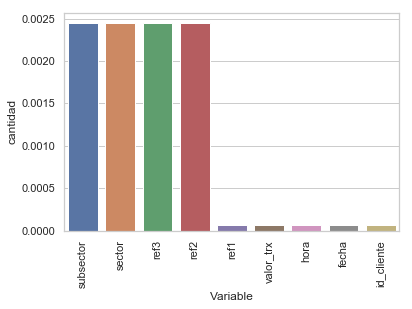

In [232]:
#ploteando el conteo de valores perdidos con seaborn
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'Variable', y = 'cantidad', data=perdidos[1:10])
plt.xticks(rotation = 90)
plt.show()

In [234]:
gasto_train = df_personas_new[['id_cliente','fecha','hora','valor_trx']]
gasto_train.tail()

,id_cliente,fecha,hora,valor_trx
499995,100032,20160906,150307,442451.26
499996,100033,20170202,140857,181825.93
499997,100033,20171120,162051,184439.26
499998,100038,20171211,83423,2427033.11
499999,100038,20180305,84723,15454.92


In [170]:
gasto_train = gasto_train.replace('',None)
gasto_train = gasto_train.replace('\\N',None)

In [171]:
gasto_train[gasto_train['hora'].notnull()==False]

,id_cliente,fecha,hora,valor_trx
25392,None,None,None,None
25393,None,None,None,None
25394,CC,None,None,None
26359,None,None,None,None
26360,None,None,None,None
73663,None,None,None,None
73664,CC,None,None,None
87730,None,None,None,None
87731,CC,None,None,None
88883,None,None,None,None


In [172]:
gasto_train = gasto_train.dropna()

In [173]:
gasto_train.count()

id_cliente    499944
fecha         499944
hora          499944
valor_trx     499944
dtype: int64

In [174]:
gasto_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499944 entries, 0 to 499999
Data columns (total 4 columns):
id_cliente    499944 non-null object
fecha         499944 non-null object
hora          499944 non-null object
valor_trx     499944 non-null object
dtypes: object(4)
memory usage: 19.1+ MB


In [175]:
gasto_train['fecha'].unique()

array(['20161207', '20161016', '20180120', '20180326', '20170106',
       '20180307', '20170210', '20180220', '20170914', '20171212',
       '20170201', '20170301', '20180803', '20170721', '20180707',
       '20180808', '20161118', '20171003', '20171206', '20180213',
       '20180705', '20180305', '20180507', '20180903', '20170330',
       '20180619', '20180821', '20171130', '20161125', '20170327',
       '20170829', '20171205', '20180919', '20170602', '20170704',
       '20170811', '20171031', '20171108', '20180306', '20180917',
       '20180528', '20170814', '20170911', '20180716', '20160905',
       '20170306', '20170116', '20170523', '20170722', '20171019',
       '20171114', '20170307', '20161116', '20170214', '20170317',
       '20170410', '20170417', '20170608', '20170621', '20170718',
       '20180518', '20180728', '20180815', '20170404', '20170612',
       '20171013', '20170827', '20170217', '20161113', '20180914',
       '20180505', '20160914', '20161025', '20161110', '201611

In [176]:
gasto_train['hora'].unique()

array(['113451', '3424', '195042', ..., '192512', '54533', '52347'],
      dtype=object)

In [177]:
import math

In [226]:
gasto_train['valor_trx']=round(gasto_train['valor_trx'].astype('str').astype('float'),0)

In [203]:
gasto_train['fechadec']=round(gasto_train['fecha'].astype('str').astype('int')/470, 0)

In [204]:
gasto_train['horadec']=gasto_train['hora'].astype('str').astype('float')/86400

In [209]:
gasto_train['timestamp']=round(((gasto_train['fechadec']+gasto_train['horadec'])*354856), 0)

In [210]:
gasto_train['timestamp']=pd.to_datetime(gasto_train['timestamp']/10, unit='s')

In [227]:
gasto_train.head()

,id_cliente,fecha,hora,valor_trx,fechadec,horadec,fechadec2,timestamp
0,3,20161207,113451,2122393.0,42896.0,1.313090,1.522237e+10,2018-03-28 11:34:53.400000095
1,10,20161016,3424,148438.0,42896.0,0.039630,1.522192e+10,2018-03-27 23:01:43.900000095
2,10,20180120,195042,94025.0,42936.0,2.257431,1.523690e+10,2018-04-14 07:10:27.900000095
3,10,20180326,192146,94430.0,42937.0,2.223912,1.523724e+10,2018-04-14 16:42:04.099999905
4,18,20170106,201317,670646.0,42915.0,2.330058,1.522947e+10,2018-04-05 16:53:27.500000000


In [228]:
gasto_training = gasto_train[['id_cliente', 'timestamp', 'valor_trx']]

Cada id_cliente tiene una serie temporal asociada de datos de valor de la transacción. Para un cliente determinado, las transacciones se proporcionan en pasos de tiempo por fecha y hora. En otras palabras, cada fila de pse representa una hora de datos de id_cliente. Cada id_cliente único en pse tiene ______ semanas o ___ días de datos por hora.
Veamos cuantos clientes tenemos y a qué cantidad de datos de entrenamiento corresponden.

In [229]:
def describe_training_data(train_df):
    num_training_series = train_df.id_cliente.nunique()
   # num_training_days = num_training_series * 28
  #  num_training_hours = num_training_days * 24
   # assert num_training_hours == train_df.shape[0]
    
    desc = f'Hay {num_training_series} series para entrenamiento ' \
          # f'total {num_training_days} días ' \
          # f'({num_training_hours} horas) de datos transaccionales.'
    
    print(desc)
    
describe_training_data(gasto_training)

Hay 157040 series para entrenamiento 



¡Son muchos datos! Para acelerar el desarrollo y facilitar la creación rápida de prototipos, hacemos reducción del conjunto de entrenamiento. Dado que todas las series de entrenamiento tienen la misma longitud(******), vamos a muestrear de forma uniforme un subconjunto de series de clientes. El tamaño de los datos reducidos resultantes será controlado por frac_series_to_use.

In [230]:
# escoger el subconjunto de clientes para entrenamiento
frac_series_to_use = 0.01

rng = np.random.RandomState(seed=RANDOM_SEED)
series_ids = gasto_training.id_cliente.unique()
series_mask = rng.binomial(1,
                           frac_series_to_use,
                           size=series_ids.shape).astype(bool)

training_series = series_ids[series_mask]

# reduce training data to series subset
gasto_training = gasto_training[gasto_training.id_cliente.isin(training_series)]

# describe the reduced set
describe_training_data(gasto_training)

Hay 1517 series para entrenamiento 


Lo anterior, acelerará un poco el procesamiento.

In [238]:
# seleccionar unos pocos patrones de clientes
series_to_plot = rng.choice(gasto_training.id_cliente.unique(), 3)
series_to_plot

array(['256646', '331633', '261329'], dtype=object)

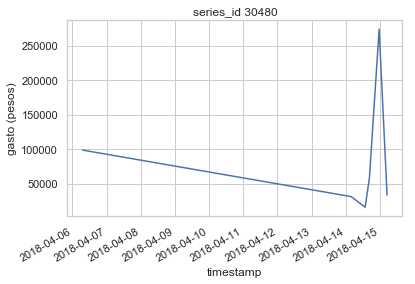

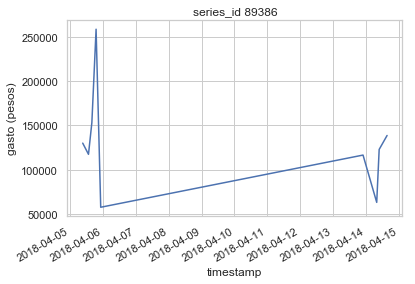

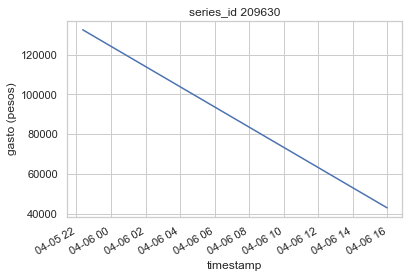

In [240]:
# graficar unos pocos patrones
series_to_plot = rng.choice(gasto_training.id_cliente.unique(), 3)

for ser_id in series_to_plot:
    ser_data = gasto_training[gasto_training.id_cliente == ser_id]
    ax = ser_data.plot(x='timestamp',
                       y='valor_trx', 
                       title=f"series_id {int(ser_id)}",
                       legend=False)
    plt.ylabel('gasto (pesos)')
    plt.show()

Red Long Short Term Memory (LSTM)

Las redes de memoria a corto y largo plazo (LSTM) pueden aprender patrones a lo largo de secuencias largas y no dependen necesariamente de una ventana preespecificada de observación retrasada como entrada. Además, sus estados internos se pueden construir para incluir información sobre los datos de arranque en frío antes de hacer cualquier cantidad de predicciones de pronóstico que solicitamos. Esto significa que un solo modelo LSTM puede manejar todos los horizontes de predicción en los datos. Nuestro enfoque general será capacitar a la red en series de 4 semanas, luego usar los datos de arranque en frío para cebar el estado interno de la red para el pronóstico y luego pronosticar.

A continuación, veremos lo que se necesita para configurar un modelo de pronóstico de un paso utilizando la capa Keras LSTM. En primer lugar, vamos a considerar cómo procesar los datos a continuación.

Preparando los datos Los procesamiento de adecuado de datos siempre es importante. Para preparar nuestros datos con el fin de modelar con un LSTM, consideremos algunos enfoques estándar.

Escalada Debido a su dependencia de la propagación hacia atrás, las redes LSTM se comportan mejor cuando los datos están dentro de la escala de la función de activación utilizada (tanh por defecto en LSTM, dominio (−1,1)). El *MinMaxScaler de Scikit Learn es suficiente para esta tarea, ya que nos permite especificar un rango e invertir transformaciones.

Estacionario A menudo, en los problemas de series de tiempo, usted quiere asegurarse de que sus datos estén estacionados, y hacerlo así si no lo está (por ejemplo, utilizando la diferenciación). Eso está más allá del alcance de este punto de referencia

Conversión de series temporales a supervisadas Usaremos un enfoque estándar de variable rezagada para convertir el problema de series temporales en un problema de aprendizaje supervisado, donde las características X y las etiquetas dadas "y" el modelo aprende un mapeo entre ellas. En este caso, las características son nuestra serie retrasada y la etiqueta es la serie original. Este proceso se puede usar con cualquier modelo, pero la ventaja aquí es que podemos usar un LSTM con estado que aprende las dependencias entre cada paso de tiempo en los datos.

Creación de características retrasadas para series temporales
Como se mencionó anteriormente, desearemos convertir cada serie en una matriz de variables retrasadas. El método de cambio de Pandas en DataFrames lo hace manejable.

In [243]:
def create_lagged_features(df, lag=1):
    if not type(df) == pd.DataFrame:
        df = pd.DataFrame(df, columns=['valor_trx'])
    
    def _rename_lag(ser, j):
        ser.name = ser.name + f'_{j}'
        return ser
        
    # add a column lagged by `i` steps
    for i in range(1, lag + 1):
        df = df.join(df.valor_trx.shift(i).pipe(_rename_lag, i))

    df.dropna(inplace=True)
    return df

# example series
test_series = gasto_training[gasto_training.id_cliente == '89386']
create_lagged_features(test_series.valor_trx, lag=3).head()

,valor_trx,valor_trx_1,valor_trx_2,valor_trx_3
476300,258566.0,138741.0,123012.0,57805.0
476301,117506.0,258566.0,138741.0,123012.0
476756,130116.0,117506.0,258566.0,138741.0
476757,153260.0,130116.0,117506.0,258566.0
476758,116645.0,153260.0,130116.0,117506.0


Función para preparar datos de entrenamiento para el modelo

Antes de procesar cada serie, deberemos convertirla en un problema de aprendizaje supervisado y luego escalar los datos. Vamos a crear una función, prepare_training_data que podamos llamar a cada muestra en nuestro ciclo de entrenamiento.

In [246]:
from sklearn.preprocessing import MinMaxScaler

def prepare_training_data(consumption_series, lag):
    """ Converts a series of consumption data into a
        lagged, scaled sample.
    """
    # scale training data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    consumption_vals = scaler.fit_transform(consumption_series.values.reshape(-1, 1))
    
    # convert consumption series to lagged features
    consumption_lagged = create_lagged_features(consumption_vals, lag=lag)

    # X, y format taking the first column (original time series) to be the y
    X = consumption_lagged.drop('valor_trx', axis=1).values
    y = consumption_lagged.valor_trx.values
    
    # keras expects 3 dimensional X
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    return X, y, scaler

_X, _y, scaler = prepare_training_data(test_series.valor_trx, 5)
print(_X.shape)
print(_y.shape)
print(scaler)

(4, 1, 5)
(4,)
MinMaxScaler(copy=True, feature_range=(-1, 1))


Ahora estamos listos para construir el modelo. Una sola celda LSTM seguida de una capa densa para la regresión es un modelo base simple con el que podemos comenzar. Importemos objetos Keras con un backend Tensorflow

In [247]:
# modeling
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense

# progress bar
from tqdm import tqdm

Using TensorFlow backend.


Como es habitual en Keras, las importaciones desde un modelo personalizado simple se realizan en unas pocas líneas. A continuación, crearemos una instancia de la configuración secuencial de Keras y le agregaremos una sola celda recurrente seguida de una capa densa para generar valores regresivos. También mantendremos el número de neuronas en la célula LSTM (esto es solo la dimensionalidad de la salida de LSTM) y el número de pasos a través de los datos pequeños.

Tenga en cuenta la importancia de establecer stateful = True a continuación. Esto permite que el LSTM aprenda los patrones dentro de un lote (los datos de la serie retrasada). De lo contrario, el estado se restablecería después de cada paso de tiempo, pero queremos que el modelo desarrolle estados que dependan de cada paso de tiempo que lo mostremos.

In [248]:
# lag of 24 to simulate smallest cold start window. Our series
# will be converted to a num_timesteps x lag size matrix
lag =  24

# model parameters
num_neurons = 24
batch_size = 1  # this forces the lstm to step through each time-step one at a time
batch_input_shape=(batch_size, 1, lag)

# instantiate a sequential model
model = Sequential()

# add LSTM layer - stateful MUST be true here in 
# order to learn the patterns within a series
model.add(LSTM(units=num_neurons, 
              batch_input_shape=batch_input_shape, 
              stateful=True))

# followed by a dense layer with a single output for regression
model.add(Dense(1))

# compile
model.compile(loss='mean_absolute_error', optimizer='adam')

Entrenamiento del modelo

Para entrenar, pasamos por los datos de consumo, agrupados por id_cliente. Para cada serie, primero preparamos los datos de entrenamiento y luego los ajustamos usando esos datos, restableciendo el estado solo después de que se haya visto cada fila de la serie. De esta manera, cada serie de tiempo retrasada es aprendida por la red antes de que se restablezca el estado y se pase la siguiente serie.

Para mantener este ejemplo rápido, solo vamos a hacer una sola pasada a través de los datos. Una forma fácil de mejorar este punto de referencia es simplemente cambiar num_passes_through_data a continuación (a un número mucho mayor).

In [249]:
%%time
num_training_series = gasto_training.id_cliente.nunique()
num_passes_through_data = 3

for i in tqdm(range(num_passes_through_data), 
              total=num_passes_through_data, 
              desc='Aprendizaje de tendencias de gasto - Epocas'):
    
    # reset the LSTM state for training on each series
    for ser_id, ser_data in gasto_training.groupby('id_cliente'):

        # prepare the data
        X, y, scaler = prepare_training_data(ser_data.valor_trx, lag)

        # fit the model: note that we don't shuffle batches (it would ruin the sequence)
        # and that we reset states only after an entire X has been fit, instead of after
        # each (size 1) batch, as is the case when stateful=False
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()

Aprendizaje de tendencias de gasto - Epocas: 100%|███████████████████████████████████████| 3/3 [01:56<00:00, 39.00s/it]


Wall time: 1min 56s
